In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [2]:
#standard imports
import time
import numpy as np
import h5py
import scipy.stats as stats

In [3]:
#importing tensorflow w/o gpus
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"    
import tensorflow as tf

In [4]:
sess = tf.Session()

In [5]:
import optimizer; reload(optimizer)

<module 'optimizer' from 'optimizer.pyc'>

# Retinal Models and Neural Coding

The retina comprises the first component of visual processing, and even at this level, the retina must compress visual information from 100 million photoreceptors down to 1 million ganglion (output) cells. In just a few layers, the retina predicts object motion [1], predicts complex spatiotemporal patterns [2], and can reduce spatiotemporal redudancy in natural scenes [3].

We will be analyzing data recorded in the Baccus Lab from a salamander retinal ganglion cell (RGC) in response to a white noise stimulus. We will use a simple encoding model known as a Linear-Nonlinear (LN) model [4] that predicts the RGC response to the stimulus, and we will use spike-triggered analysis [5] to compute its linear receptive field. This will then motivate the use of deeper encoding models featured in [6], which you will explore in your upcoming homework assignment.

## Data 

In [6]:
rootdir = '/mnt/data3/yamins/retina/tf_records/'

In [7]:
import tfutils.data as data

In [8]:
class retinaTF(data.TFRecordsParallelByFileProvider):

    def __init__(self,
               source_dirs,
               resize=50,
               **kwargs
               ):

        if resize is None:
          self.resize = 50
        else:
          self.resize = resize

        postprocess = {'images': [], 'labels': []}
        postprocess['images'].insert(0, (tf.decode_raw, (tf.float32, ), {})) 
        postprocess['images'].insert(1, (tf.reshape, ([-1] + [50, 50, 40], ), {}))
        postprocess['images'].insert(2, (self.postproc_imgs, (), {})) 

        postprocess['labels'].insert(0, (tf.decode_raw, (tf.float32, ), {})) 
        postprocess['labels'].insert(1, (tf.reshape, ([-1] + [5], ), {}))

        super(retinaTF, self).__init__(
          source_dirs,
          postprocess=postprocess,
          **kwargs
        )
    
    def postproc_imgs(self, ims):
        def _postprocess_images(im):
            im = tf.image.resize_images(im, [self.resize, self.resize])
            return im
        return tf.map_fn(lambda im: _postprocess_images(im), ims, dtype=tf.float32)


In [9]:
dp_train_wn = retinaTF(source_dirs=[os.path.join(rootdir, 'whitenoise', 'images'),
                                 os.path.join(rootdir, 'whitenoise', 'labels')],
                    file_pattern='train_*',
                    batch_size=5000)

data_train_op_wn = dp_train_wn.init_ops()

train_queue_wn = data.get_queue(data_train_op_wn[0],
                                queue_type='random',
                                batch_size=1024)

train_enqueue_ops_wn = [train_queue_wn.enqueue_many(data_train_op_wn[0])]

tf.train.queue_runner.add_queue_runner(tf.train.queue_runner.QueueRunner(train_queue_wn,
                                                                         train_enqueue_ops_wn))
inputs_train_wn = train_queue_wn.dequeue_many(5000)

INFO:tfutils:Using all metadata from saved source


In [10]:
dp_test_wn = retinaTF(source_dirs=[os.path.join(rootdir, 'whitenoise', 'images'),
                                 os.path.join(rootdir, 'whitenoise', 'labels')],
                    file_pattern='test_*',
                    batch_size=5000)

data_test_op_wn = dp_test_wn.init_ops()

test_queue_wn = data.get_queue(data_test_op_wn[0],
                                queue_type='fifo',
                                batch_size=1024)

test_enqueue_ops_wn = [test_queue_wn.enqueue_many(data_test_op_wn[0])]

tf.train.queue_runner.add_queue_runner(tf.train.queue_runner.QueueRunner(test_queue_wn,
                                                                    test_enqueue_ops_wn))
inputs_test_wn = test_queue_wn.dequeue_many(5957)

INFO:tfutils:Using all metadata from saved source


In [11]:
dp_train_ns = retinaTF(source_dirs=[os.path.join(rootdir, 'naturalscene', 'images'),
                                 os.path.join(rootdir, 'naturalscene', 'labels')],
                    file_pattern='train_*',
                    batch_size=5000)

data_train_op_ns = dp_train_ns.init_ops()

train_queue_ns = data.get_queue(data_train_op_ns[0],
                                queue_type='random',
                                batch_size=1024)

train_enqueue_ops_ns = [train_queue_ns.enqueue_many(data_train_op_ns[0])]

tf.train.queue_runner.add_queue_runner(tf.train.queue_runner.QueueRunner(train_queue_ns,
                                                                         train_enqueue_ops_ns))
inputs_train_ns = train_queue_ns.dequeue_many(5000)

INFO:tfutils:Using all metadata from saved source


In [12]:
dp_test_ns = retinaTF(source_dirs=[os.path.join(rootdir, 'naturalscene', 'images'),
                                 os.path.join(rootdir, 'naturalscene', 'labels')],
                    file_pattern='test_*',
                    batch_size=5000)

data_test_op_ns = dp_test_ns.init_ops()

test_queue_ns = data.get_queue(data_test_op_ns[0],
                                queue_type='fifo',
                                batch_size=1024)

test_enqueue_ops_ns = [test_queue_ns.enqueue_many(data_test_op_ns[0])]

tf.train.queue_runner.add_queue_runner(tf.train.queue_runner.QueueRunner(test_queue_ns,
                                                                         test_enqueue_ops_ns))
inputs_test_ns = test_queue_ns.dequeue_many(5956)

INFO:tfutils:Using all metadata from saved source


In [13]:
coord = tf.train.Coordinator()

In [14]:
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

The data we will be using consists of recordings of a ganglion cell from the salamander retina. In one set of stimuli there is flickering white noise, sampled at a frame rate of 100 Hz. In the other, the images are patches of natural scenes taken from a movie.  The stimulus array has dimensions 50x50 pixels. The time array contains the time (in seconds) of the stimulus presentation for each stimulus frame. The spike_times array contains the spike times of an isolated retinal ganglion cell (RGC) recorded in response to the stimulus.

In [19]:
whitenoise_data = h5py.File('/mnt/data3/yamins/retina/whitenoise.h5') 

In [20]:
naturalscene_data = h5py.File('/mnt/data3/yamins/retina/naturalscene.h5')

In [21]:
whitenoise_data.keys()

[u'spikes', u'test', u'train']

In [22]:
whitenoise_data['train'].keys()

[u'response', u'stimulus', u'time']

In [23]:
whitenoise_stimuli_train = whitenoise_data['train']['stimulus']
whitenoise_stimuli_train

<HDF5 dataset "stimulus": shape (359802, 50, 50), type "|u1">

In [24]:
whitenoise_stimuli_test = whitenoise_data['test']['stimulus']
whitenoise_stimuli_test

<HDF5 dataset "stimulus": shape (5997, 50, 50), type "|u1">

In [25]:
whitenoise_data['train']['response'].keys()

[u'binned', u'firing_rate_10ms', u'firing_rate_20ms', u'firing_rate_5ms']

In [26]:
whitenoise_responses_train = whitenoise_data['train']['response']['firing_rate_10ms']
whitenoise_responses_train

<HDF5 dataset "firing_rate_10ms": shape (9, 359802), type "<f8">

In [27]:
whitenoise_responses_test = whitenoise_data['test']['response']['firing_rate_10ms']
whitenoise_responses_test

<HDF5 dataset "firing_rate_10ms": shape (9, 5997), type "<f8">

In [28]:
naturalscene_stimuli_train = naturalscene_data['train']['stimulus']
naturalscene_stimuli_train

<HDF5 dataset "stimulus": shape (359796, 50, 50), type "|u1">

In [29]:
naturalscene_stimuli_test = naturalscene_data['test']['stimulus']
naturalscene_stimuli_test

<HDF5 dataset "stimulus": shape (5996, 50, 50), type "|u1">

In [30]:
naturalscene_responses_train = naturalscene_data['train']['response']['firing_rate_10ms']
naturalscene_responses_test = naturalscene_data['test']['response']['firing_rate_10ms']


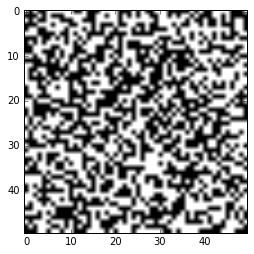

In [31]:
plt.imshow(whitenoise_stimuli_train[3], cmap='gray')

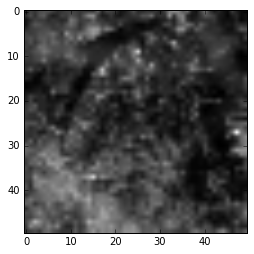

In [32]:
plt.imshow(naturalscene_stimuli_train[1100], cmap='gray')

## The Linear-Nonlinear Model

In [15]:
#ok let's define the model
def linear_nonlinear_model(data, labels, nonlinearity=tf.nn.softplus):
    data_flat = tf.layers.flatten(data) #because the data comes in as a tensor
    
    #now lets allocate weights
    num_inputs = data_flat.shape.as_list()[-1]
    num_outputs = labels.shape.as_list()[-1]
    with tf.variable_scope("ln_model"):
        b = tf.get_variable(shape=[num_outputs],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='bias') 
        W = tf.get_variable(shape=[num_inputs, num_outputs],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='weights')
        
    #here's the actual model
    linear_intermediate = tf.matmul(data_flat, W) + b
    nonlinear_output = nonlinearity(linear_intermediate)
    
    return nonlinear_output
    

In [16]:
#This is the log-likelihood loss function
def log_loss(model_output, labels, C=1):
    #loss is small when the log likehoolihood of the observed data is high
    log_loss = tf.reduce_mean(model_output - (labels * tf.log(model_output + 1e-8)))
    #we regularize the weights to (try to) prevent overfitting
    reg_loss = tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    return C * log_loss + reg_loss

In [ ]:
cls_lnns = optimizer.TF_Optimizer(model_func=linear_nonlinear_model,
             loss_func=log_loss, 
             loss_kwargs={'C':1},
             optimizer_class=tf.train.AdamOptimizer,
             train_iterations=2001,
             sess=sess,
             train_shuffle=True,
             optimizer_kwargs = {'learning_rate':1e-4}
            ) 

with tf.variable_scope("ln_naturalscene", reuse=tf.AUTO_REUSE):
    cls_lnns.fit(inputs_train_ns['images'], 
            inputs_train_ns['labels'],
            report_freq=10)

iteration 0 loss 1.940
iteration 10 loss 2.381
iteration 20 loss 0.908
iteration 30 loss 0.744
iteration 40 loss 0.686
iteration 50 loss 1.034
iteration 60 loss 0.985
iteration 70 loss 0.468
iteration 80 loss 0.624
iteration 90 loss 0.551
iteration 100 loss 0.916
iteration 110 loss 0.631
iteration 120 loss 0.960
iteration 130 loss 0.244
iteration 140 loss 0.524
iteration 150 loss 0.150
iteration 160 loss 0.662
iteration 170 loss 0.181
iteration 180 loss 0.306
iteration 190 loss 0.270
iteration 200 loss -0.058
iteration 210 loss 0.435
iteration 220 loss 0.093
iteration 230 loss 0.619
iteration 240 loss 0.531
iteration 250 loss 0.466
iteration 260 loss 0.190
iteration 270 loss 0.073
iteration 280 loss 0.099
iteration 290 loss 0.392
iteration 300 loss 0.279
iteration 310 loss 0.112
iteration 320 loss -0.089
iteration 330 loss -0.113
iteration 340 loss -0.063
iteration 350 loss 0.067
iteration 360 loss 0.092
iteration 370 loss 0.090
iteration 380 loss -0.033
iteration 390 loss -0.403
itera

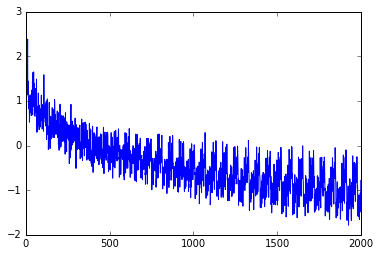

In [26]:
plt.plot(cls_lnns.losses)

In [ ]:
cls_lnwn = optimizer.TF_Optimizer(model_func=linear_nonlinear_model,
             loss_func=log_loss, 
             loss_kwargs={'C':1},
             optimizer_class=tf.train.AdamOptimizer,
             train_iterations=2001,
             sess=sess,
             train_shuffle=True,
             optimizer_kwargs = {'learning_rate':1e-4}
            ) 

with tf.variable_scope("ln_whitenoise", reuse=tf.AUTO_REUSE):
    cls_lnwn.fit(inputs_train_wn['images'], 
                 inputs_train_wn['labels'],
                 report_freq=10)

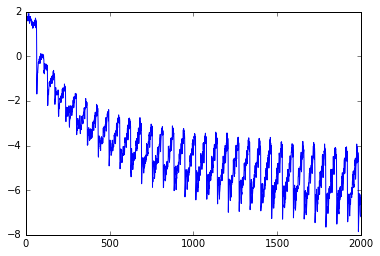

In [27]:
plt.plot(cls_lnwn.losses)

In [28]:
with tf.variable_scope("ln_naturalscene", reuse=tf.AUTO_REUSE):
    preds_ns, labs_ns = cls_lnns.predict(test_data=inputs_test_ns['images'],
                                         test_labels=inputs_test_ns['labels'], num_batches=1)


In [29]:
with tf.variable_scope("ln_whitenoise", reuse=tf.AUTO_REUSE):
    preds_wn, labs_wn = cls_lnwn.predict(test_data=inputs_test_wn['images'], 
                                    test_labels=inputs_test_wn['labels'], num_batches=1)


In [42]:
stats.pearsonr(preds_ns[:, 4], labs_ns[:, 4])

(0.46082848, 5.1726699740144868e-311)

In [109]:
T = 40  #(in 10-ms slices, representing 400ms of history)
def temporal_sliding_window(data, inds):
    #this is what creates the temporal sliding window
    inds0 = np.concatenate([range(ind, ind + T) for ind in inds])
    inds0 = np.minimum(inds0, data.shape[0]-1)
    data_ss = data[inds0]
    shp = data_ss.shape
    n0 = shp[0] / T
    data_ss = data_ss.reshape((n0, T) + shp[1:])
    return data_ss.astype(np.float32)    


cls = optimizer.TF_Optimizer(model_func=linear_nonlinear_model,
             loss_func=log_loss, 
             loss_kwargs={'C':1},
             optimizer_class=tf.train.AdamOptimizer,
             batch_size=2500,
             train_iterations=2001,
             sess=sess,
             train_shuffle=True,
             optimizer_kwargs = {'learning_rate':1e-3},
             data_processors={'data': temporal_sliding_window}
            )

In [ ]:
#ok let's actually fit it. 
with tf.variable_scope("ln_whitenoise", reuse=tf.AUTO_REUSE):
    cls.fit(whitenoise_train_processed[0], 
            whitenoise_train_processed[1])
    
#loss has reduced reasonably. 

iteration 0 loss 2.729
iteration 100 loss -1.299
iteration 200 loss -4.158


In [36]:
#let's check out the predictions
preds = cls.predict(whitenoise_test_processed[0])

In [38]:
for neuron in range(5):
    corr = stats.pearsonr(preds[:, neuron],
                          whitenoise_test_processed[1][:, neuron])[0]
    print("Test Correlation for neuron %d: %.3f" % (neuron, corr))
    
#oof -- horrible.   

Test Correlation for neuron 0: 0.044
Test Correlation for neuron 1: -0.028
Test Correlation for neuron 2: -0.017
Test Correlation for neuron 3: 0.079
Test Correlation for neuron 4: -0.038


In [39]:
#is it just as bad on the training data?

preds1 = cls.predict(whitenoise_train_processed[0][:5000])

for neuron in range(5):
    corr = stats.pearsonr(preds1[:, neuron],
                          whitenoise_train_processed[1][:, neuron][:5000])[0]
    print("Train Correlation for neuron %d: %.3f" % (neuron, corr))
    
#not bad at all

#so we're obviously seeing some form of bad overfitting. 

Train Correlation for neuron 0: 0.567
Train Correlation for neuron 1: 0.563
Train Correlation for neuron 2: 0.376
Train Correlation for neuron 3: 0.558
Train Correlation for neuron 4: 0.581


In [ ]:
#let's try on the natural scene data. 

In [44]:
cls_natural = optimizer.TF_Optimizer(model_func=linear_nonlinear_model,
             loss_func=log_loss, 
             optimizer_class=tf.train.AdamOptimizer,
             batch_size=5000,
             train_iterations=501,
             sess=sess,
             train_shuffle=True,
             optimizer_kwargs = {'learning_rate':1e-4},
             data_processors={'data': get_temporal_batch}
            )

In [74]:
with tf.variable_scope("ln_natural", reuse=tf.AUTO_REUSE):
    cls_natural.fit(naturalscene_train_processed[0], 
                    naturalscene_train_processed[1])

iteration 0 loss 2.164
iteration 100 loss 1.686
iteration 200 loss 1.495
iteration 300 loss 1.197
iteration 400 loss 1.284
iteration 500 loss 1.141


In [79]:
preds_natural = cls_natural.predict(naturalscene_test_processed[0])

for neuron in range(5):
    corr = stats.pearsonr(preds_natural[:, neuron],
                          naturalscene_test_processed[1][:, neuron])[0]
    print("naturalscene Test Correlation for neuron %d: %.3f" % (neuron, corr))
    
#oof -- still horrible.   
#I'm not able to reproduce the results of the paper yet. 

naturalscene Test Correlation for neuron 0: 0.002
naturalscene Test Correlation for neuron 1: 0.042
naturalscene Test Correlation for neuron 2: 0.014
naturalscene Test Correlation for neuron 3: 0.005
naturalscene Test Correlation for neuron 4: 0.028


### LNLN model

In [108]:
def lnln_model(data, labels, num_intermediate, nonlinearity=tf.nn.softplus):
    data_flat = tf.layers.flatten(data) 
    num_inputs = data_flat.shape.as_list()[-1]
    num_outputs = labels.shape.as_list()[-1]
    with tf.variable_scope("ln_model", reuse=tf.AUTO_REUSE):
        b1 = tf.get_variable(shape=[num_intermediate],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='bias1') 
        W1 = tf.get_variable(shape=[num_inputs, num_intermediate],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='weights1')
        b2 = tf.get_variable(shape=[num_outputs],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='bias2') 
        W2 = tf.get_variable(shape=[num_intermediate, num_outputs],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='weights2')     
        
    intermediate_synapse = nonlinearity(tf.matmul(data_flat, W1) + b1)
    
    out = nonlinearity(tf.matmul(intermediate_synapse, W2) + b2)
    
    return out
    

In [87]:
cls_lnln = optimizer.TF_Optimizer(model_func=lnln_model,
                                  model_kwargs={'num_intermediate':10},
             loss_func=log_loss, 
             loss_kwargs={'C':1},
             optimizer_class=tf.train.AdamOptimizer,
             batch_size=2500,
             train_iterations=501,
             sess=sess,
             train_shuffle=True,
             optimizer_kwargs = {'learning_rate':1e-4},
             data_processors={'data': temporal_sliding_window}
            )

In [88]:
with tf.variable_scope("lnln_natural", reuse=tf.AUTO_REUSE):
    cls_lnln.fit(naturalscene_train_processed[0], 
                    naturalscene_train_processed[1])

iteration 0 loss 1.196
iteration 100 loss 0.007
iteration 200 loss 0.211
iteration 300 loss -0.415
iteration 400 loss -0.477
iteration 500 loss -0.106


In [92]:
preds_natural_lnln = cls_lnln.predict(naturalscene_test_processed[0])

for neuron in range(5):
    corr = stats.pearsonr(preds_natural_lnln[:, neuron],
                          naturalscene_test_processed[1][:, neuron])[0]
    print("LNLN naturalscene Test Correlation for neuron %d: %.3f" % (neuron, corr))
    
#again still bad

LNLN naturalscene Test Correlation for neuron 0: 0.051
LNLN naturalscene Test Correlation for neuron 1: 0.019
LNLN naturalscene Test Correlation for neuron 2: 0.006
LNLN naturalscene Test Correlation for neuron 3: 0.077
LNLN naturalscene Test Correlation for neuron 4: 0.074


## Multilayer Convolutional Models

In [73]:
from tfutils import model as tf_models

In [74]:
def cnn_model(data, labels, sigma=0.1, seed=0):

    # graph building stage
    with tf.variable_scope('cnn_model', reuse=tf.AUTO_REUSE):
        with tf.variable_scope('conv1'):
            c1 = tf_models.conv(data, 
                                out_depth=16, 
                                ksize=[15,15], 
                                strides=[1,1,1,1], 
                                padding='VALID', 
                                activation=None, 
                                batch_norm=False, 
                                weight_decay=1e-3)   
            
            r1 = tf.nn.relu(c1)

        with tf.variable_scope('conv2'):
            c2 = tf_models.conv(r1, 
                            out_depth=8, 
                            ksize=[9,9],
                            strides=[1,1,1,1],
                            padding='VALID',
                            activation=None,
                            batch_norm=False,
                            weight_decay=1e-3)

            
            r2 = tf.nn.relu(c2)

        with tf.variable_scope('readout'):
            out = tf_models.fc(r2, 
                           out_depth=5,
                           kernel_init='random_normal',
                           kernel_init_kwargs={'mean':0.0, 'stddev':0.05},
                           activation='softplus', 
                           bias=0, 
                           batch_norm=False, 
                           weight_decay=1e-3) 

    return out

## Acknowledgements

The material in this lecture was adapted from an assigment in CS 375 taught in Fall 2017 by Aran Nayebi, which was in turn taken from NEPR 208 (Neurosciences Computational Core Module), taught in Spring 2016 by Stephen A Baccus and Niru Maheswaranathan. The data used in this tutorial is from the Baccus Lab at Stanford.

## References

1. Stephen A Baccus, Bence P Olveczky, Mihai Manu, and Markus Meister. A retinal circuit that computes object motion.  The Journal of Neuroscience, 28(27):6807–6817, 2008.

2. Toshihiko Hosoya, Stephen A Baccus, and Markus Meister. Dynamic predictive coding by the retina. Nature, 436(7047):71–77, 2005.

3. Mandyam V Srinivasan, Simon B Laughlin, and Andreas Dubs. Predictive coding: a fresh view of inhibition in the retina. Proceedings of the Royal Society of London. Series B. Biological Sciences, 216(1205):427–459, 1982.

4. EJ Chichilnisky. A simple white noise analysis of neuronal light responses. Network: Computation in Neural Systems, 12(2):199-213, 2001.

5. Odelia Schwartz, Jonathan W Pillow, Nicole C Rust, and Eero P Simoncelli. Spike-triggered neural characterization. Journal of Vision, 6(4):484-507, 2006.

6. Lane T McIntosh, Niru Maheswaranathan, Aran Nayebi, Surya Ganguli, and Stephen A. Baccus. Deep learning models of the retinal response to natural scenes. In Advances in Neural Information Processing Systems (NIPS 2016), pp. 1369-1377, 2016.

In [55]:
import numpy as np

def flat2d(x):
    """Flattens all dimensions after the first of the given array
    Useful for collapsing spatial dimensions in a spatiotemporal
    stimulus or filter.
    """
    return x.reshape(x.shape[0], -1)
    
def lowranksta(sta_orig, k=10):
    """
    Constructs a rank-k approximation to the given spatiotemporal STA.
    This is useful for estimating a spatial and temporal kernel for an
    STA or for denoising.
    Parameters
    ----------
    sta_orig : array_like
        3D STA to be separated, shaped as ``(time, space, space)``.
    k : int
        Number of components to keep (rank of the reduced STA).
    Returns
    -------
    sk : array_like
        The rank-k estimate of the original STA.
    u : array_like
        The top ``k`` temporal components (each column is a component).
    s : array_like
        The top ``k`` singular values.
    v : array_like
        The top ``k`` spatial components (each row is a component). These
        components have all spatial dimensions collapsed to one.
    Notes
    -----
    This method requires that the STA be 3D. To decompose a STA into a
    temporal and 1-dimensional spatial component, simply promote the STA
    to 3D before calling this method.
    Despite the name this method accepts both an STA or a linear filter.
    The components estimated for one will be flipped versions of the other.
    """

    # work with a copy of the STA (prevents corrupting the input)
    f = sta_orig.copy() - sta_orig.mean()

    # Compute the SVD of the full STA
    assert f.ndim >= 2, "STA must be at least 2-D"
    u, s, v = np.linalg.svd(flat2d(f), full_matrices=False)

    # Keep the top k components
    k = np.min([k, s.size])
    u = u[:, :k]
    s = s[:k]
    v = v[:k, :]

    # Compute the rank-k STA
    sk = (u.dot(np.diag(s).dot(v))).reshape(f.shape)

    # Ensure that the computed STA components have the correct sign.
    # The full STA should have positive projection onto first temporal
    # component of the low-rank STA.
    sign = np.sign(np.tensordot(u[:, 0], f, axes=1).sum())
    u *= sign
    v *= sign

    # Return the rank-k approximate STA, and the SVD components
    return sk, u, s, v

def decompose(sta):
    """
    Decomposes a spatiotemporal STA into a spatial and temporal kernel.
    Parameters
    ----------
    sta : array_like
        The full 3-dimensional STA to be decomposed, of shape ``(t, nx, ny)``.
    Returns
    -------
    s : array_like
        The spatial kernel, with shape ``(nx * ny,)``.
    t : array_like
        The temporal kernel, with shape ``(t,)``.
    """
    _, u, _, v = lowranksta(sta, k=1)
    return v[0].reshape(sta.shape[1:]), u[:, 0]



In [49]:
w = sess.run(cls.model.op.inputs[0].op.inputs[0].op.inputs[1])

In [51]:
cls.model.op.inputs[0].op.inputs[0].op.inputs[1]

<tf.Tensor 'ln_whitenoise_4/ln_model/weights/read:0' shape=(100000, 5) dtype=float32>

In [62]:
wrs = w.reshape((40, 50, 50, 5))

In [72]:
a, b = decompose(wrs[:,:,:, 4])

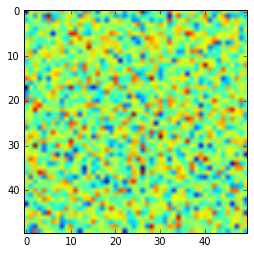

In [73]:
plt.imshow(a)